In [22]:
import pandas as pd
from sklearn import preprocessing 
import matplotlib.pyplot as plt
import plotly.express as px

In [3]:
df = pd.read_csv("../data/segmented_customers.csv")
df.head()

,CustomerID,Gender,Age,Annual Income (k$),Spending Score (1-100),cluster
0,1,Male,19.0,15.0,39.0,4.0
1,2,Male,21.0,15.0,81.0,3.0
2,3,Female,20.0,16.0,6.0,4.0
3,4,Female,23.0,16.0,77.0,3.0
4,5,Female,31.0,17.0,40.0,4.0


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 205 entries, 0 to 204
Data columns (total 6 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   CustomerID              205 non-null    int64  
 1   Gender                  205 non-null    object 
 2   Age                     203 non-null    float64
 3   Annual Income (k$)      203 non-null    float64
 4   Spending Score (1-100)  204 non-null    float64
 5   cluster                 201 non-null    float64
dtypes: float64(4), int64(1), object(1)
memory usage: 9.7+ KB


In [6]:
df[df['Age'].isnull()]

,CustomerID,Gender,Age,Annual Income (k$),Spending Score (1-100),cluster
203,204,Male,NaN,16.0,120.0,NaN
204,205,Female,NaN,9.0,80.0,NaN


In [9]:
df[df.isna().any(axis=1)]


,CustomerID,Gender,Age,Annual Income (k$),Spending Score (1-100),cluster
200,201,Female,21.0,NaN,40.0,0.0
201,202,Female,30.0,127.0,NaN,NaN
202,203,Male,80.0,NaN,20.0,NaN
203,204,Male,NaN,16.0,120.0,NaN
204,205,Female,NaN,9.0,80.0,NaN


In [10]:
df = df.dropna(axis=0)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 200 entries, 0 to 199
Data columns (total 6 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   CustomerID              200 non-null    int64  
 1   Gender                  200 non-null    object 
 2   Age                     200 non-null    float64
 3   Annual Income (k$)      200 non-null    float64
 4   Spending Score (1-100)  200 non-null    float64
 5   cluster                 200 non-null    float64
dtypes: float64(4), int64(1), object(1)
memory usage: 10.9+ KB


In [11]:
# переименуем столбцы для более удобной работы
df.rename(columns = {'CustomerID' : 'customer_id', 'Gender' : 'gender', 
                    'Age': 'age', 'Annual Income (k$)': 'annual_income', 
                    'Spending Score (1-100)': 'spending_score', }, inplace = True)

In [21]:
df[df.duplicated(subset=['customer_id'])]


,customer_id,gender,age,annual_income,spending_score,cluster


In [71]:
px.scatter_3d(
    df,
    y='annual_income',
    z='spending_score',
    x='age',
    color='cluster',
    width=1000,
    height=700
)

DBSCAN плох т.к данные разрежены

In [78]:
from sklearn.cluster import DBSCAN
db_model = DBSCAN(eps = 11, min_samples=5)
db_model.fit(df[['annual_income','spending_score', 'age',]])
px.scatter_3d(
    df,
    y='annual_income',
    z='spending_score',
    x='age',
    color=db_model.labels_,
    width=1000,
    height=700
)


In [72]:
def get_3d_visualization(df, clust_res):
    fig = px.scatter_3d(
        data_frame=df, 
        x = 'age', 
        y = 'annual_income', 
        z = 'spending_score', 
        color = clust_res,
        width=1000,
        height=700
    )

    #возвращаем график
    return fig

In [83]:
X = df[['age', 'annual_income', 'spending_score']]

In [79]:
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram, linkage

In [110]:
def get_agg_clustering(X, n_clustering):
    agg_clust = AgglomerativeClustering(n_clusters=n_clustering, linkage='ward')
    agg_pred = agg_clust.fit_predict(X)
    return agg_pred
def get_dendrogram(X, label_pred):
    z = linkage(X, method='ward')
    fig = plt.figure(figsize=(10,8))
    dendrogram(z,
               labels=label_pred,
               orientation='top',
               distance_sort='descending',
               show_leaf_counts=True,
               )

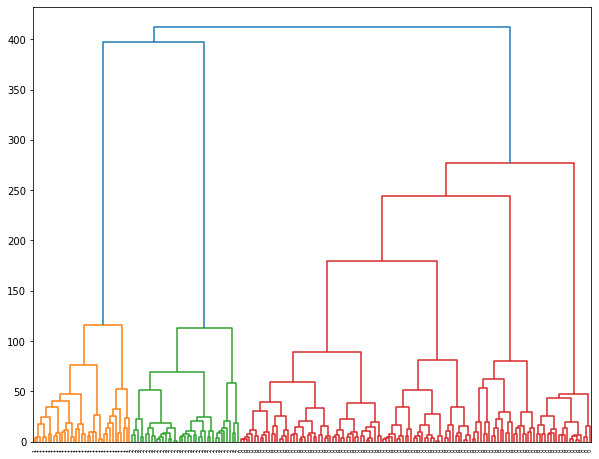

In [109]:
agg_pred_3 = get_agg_clustering(X, 3)
get_dendrogram(X, agg_pred_3)


Попробуем взять 6 кластеров

In [111]:
agg_preds_6 = get_agg_clustering(X, 6)
get_3d_visualization(X, agg_preds_6)

In [112]:
from sklearn.metrics import silhouette_score

In [129]:
silh_dict = {'silhouette_scores': [silhouette_score(X, get_agg_clustering(X, n)) for n in range(2,10)],
           'n_clusters': [i for i in range(2, 10)]}
silh_df = pd.DataFrame(silh_dict)
px.line(silh_df, 'n_clusters', 'silhouette_scores', markers=True, labels={})

In [140]:
from sklearn.metrics import homogeneity_completeness_v_measure
homogeneity_completeness_v_measure(labels_true=df['cluster'], labels_pred=get_agg_clustering(X,6))

(0.8961688909683594, 0.9012847747610448, 0.8987195524915056)